In [1]:
# Maybe?:
# https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0

### Module 16: Learning Notebook: Principle Component Analysis

PCA is a statistical procedure that converts a set of features of possibly correlated variables into a set of features of linearly uncorrelated variables called principal components. <P>

In simpler words, PCA converts many features into just a few. It's puprpose is to simplify data, reduce noise, and find hidden “latent variables” that better represent your data. <P>

This means that PCA will help us to find a reduced number of features that will represent our original dataset in a compressed way, capturing up to a **certain portion of its variance** depending on the number of new features we end up selecting. <P>

Advantages of PCA:
- Lack of redundancy of data given the orthogonal components.
- Principal components are independent of each other, so removes correlated features.
- PCA improves the performance of the ML algorithm as it eliminates correlated variables that don't contribute in any decision making.
- PCA helps in overcoming data overfitting issues by decreasing the number of features.
- PCA results in high variance and thus improves visualization.
- Reduction of noise since the maximum variation basis is chosen and so the small variations in the background are ignored automatically.

    
Disadvantages of PCA:
- It is difficult to evaluate the covariance in a proper way.
- Even the simplest invariance could not be captured by the PCA unless the training data explicitly provide this information.
- Data needs to be standardized before implementing PCA else it becomes difficult to identify optimal principal components.
- Though PCA covers maximum variance amid data features, sometimes it may skip a bit of information in comparison to the actual list of features.
- Implementing PCA over datasets leads to transforming actual features in principal components that are linear combinations of actual features, therefore principle components are difficult to read or interpret as compared to actual features.

In [2]:
# Load libraries
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline

In [3]:
# load boston.csv from S3
sess = boto3.session.Session()
s3 = sess.client('s3') 
source_bucket = 'machinelearning-read-only'
source_key = 'data/boston.csv'
response = s3.get_object(Bucket=source_bucket, Key=source_key)
df = pd.read_csv(response.get("Body"))
df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Recall: a correlation matrix

In [4]:
# Generate the corelation between all pairs of features
#      https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
corr_df = df.corr() # Still returns a dataframe
# Show just the first 5 rows & cols
corr_df.iloc[:5,:5]

,CRIM,ZN,INDUS,CHAS,NOX
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000


In [5]:
# From an earlier module
corr_df.style.background_gradient(cmap='coolwarm').format(precision=2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


### Fit a simple linear model and evaluate

In [6]:
# Features
X = df.drop(['MEDV'],axis = 1)
# Target
y = df['MEDV']
# Split into train/test
# Reserve 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state = 42)
# Verify the sizes of the split datasets
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (404, 13)
y_train: (404,)
X_test: (102, 13)
y_test: (102,)


In [7]:
# Use a pipeline with a Standard Scaler
scaler = StandardScaler()
lr = linear_model.LinearRegression()
steps = [('Scaler', scaler), ('LinReg', lr)]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficient of determination: 0.67


### Perform PCA

In [9]:
# We are now only focused on the feature matrix:
X.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14


In [14]:
# Setup a scaler-PCA pipeline
#
scaler = StandardScaler() # Standardize the data
# Create a PCA model. This is just like a regular algorithm
pca = PCA(n_components = 13,random_state = 11) # first, let' use all features
#
steps = [('Scaler', scaler), ('PCA', pca)]
# Create a pipeline
pipe = Pipeline(steps)
# Fit
pipe.fit(X)
# Transform
principle_array = pipe.transform(X)
# Build a df
pca_cols = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10','pc11','pc12','pc13']
principal_df = pd.DataFrame(data = principle_array,columns = pca_cols)
print('Original Columns:', X.columns)
principal_df.head(3)
# Explain what these PC represent: 

Original Columns: Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
0,-2.098297,0.773113,0.342943,-0.891774,0.423070,-0.315338,0.318641,0.295832,-0.424937,0.640206,-0.033000,0.019440,0.365975
1,-1.457252,0.591985,-0.695199,-0.487459,-0.195876,0.264223,0.553861,-0.223670,-0.166962,0.084236,-0.640810,-0.125797,-0.070719
2,-2.074598,0.599639,0.167122,-0.739204,-0.934534,0.448095,0.484560,0.105166,0.069775,-0.180380,-0.487557,0.133327,-0.014022


In [15]:
# Generate the corelation plot. Look, no correlation!
principal_corr_df = principal_df.corr()
principal_corr_df.style.background_gradient(cmap='coolwarm').format(precision=2)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
pc1,1.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00
pc2,0.00,1.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00
pc3,-0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00
pc4,0.00,0.00,-0.00,1.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00
pc5,-0.00,0.00,-0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00
pc6,0.00,0.00,0.00,0.00,-0.00,1.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00
pc7,0.00,0.00,0.00,0.00,-0.00,0.00,1.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00
pc8,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,1.00,-0.00,-0.00,0.00,-0.00,0.00
pc9,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,1.00,0.00,0.00,0.00,0.00
pc10,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,1.00,0.00,-0.00,0.00


#### Goal: capture much of the variance, but try to reduce the number of features

Use the **pca.explained_variance_ratio_** attribute

In [16]:
# The explained_variance_ratio_ attribute of the PCA() class returns a 
# one-dimensional numpy array which contains the values of the percentage
# of variance explained by each of the selected components.
#
# We didn't lose anything. We caputured all the variance
print('Variance explained by all 13 principal components = ',sum(pca.explained_variance_ratio_))

Variance explained by all 13 principal components =  1.0


In [17]:
# How much variance does each PC capture? Just the first 5 gets 80% of the variance
#  explained_variance_ratio_ is ordered from most variance to least
cum_sum = 0
for pc in range(0,5):
    cum_sum = cum_sum + pca.explained_variance_ratio_[pc]
    print('PC #',pc+1,':',pca.explained_variance_ratio_[pc])
    print('Cumulative Sum: ',cum_sum,'\n')

PC # 1 : 0.4712960635727467
Cumulative Sum:  0.4712960635727467 

PC # 2 : 0.11025193247588012
Cumulative Sum:  0.5815479960486268 

PC # 3 : 0.09558589792622932
Cumulative Sum:  0.6771338939748561 

PC # 4 : 0.06596731600836156
Cumulative Sum:  0.7431012099832177 

PC # 5 : 0.06421661052137363
Cumulative Sum:  0.8073178205045913 



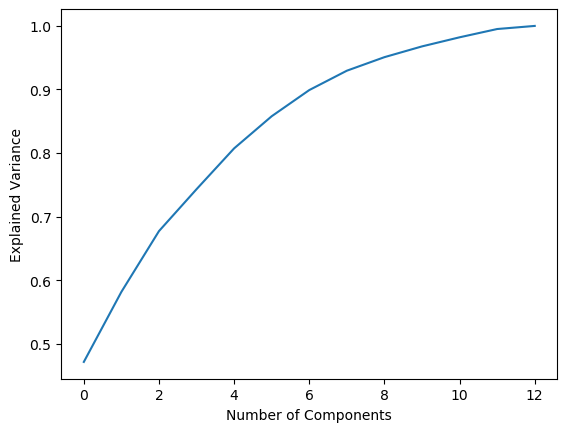

In [18]:
# Show the captured variance curve
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

#### Decide how many PCs are 'enough'

In [19]:
reduced_pca = PCA(n_components = 5, random_state = 11)
steps = [('Scaler', scaler), ('PCA', reduced_pca)]
pipe = Pipeline(steps)
pipe.fit(X)
principle_array = pipe.transform(X)
reduced_pca_cols = ['pca1','pca2','pca3','pca4','pca5']
reduced_df = pd.DataFrame(data = principle_array,columns = reduced_pca_cols)
print('This will capture = ',sum(reduced_pca.explained_variance_ratio_))
reduced_df.head()

This will capture =  0.8073178205045917


,pca1,pca2,pca3,pca4,pca5
0,-2.098297,0.773113,0.342943,-0.891774,0.423070
1,-1.457252,0.591985,-0.695199,-0.487459,-0.195876
2,-2.074598,0.599639,0.167122,-0.739204,-0.934534
3,-2.611504,-0.006871,-0.100284,-0.343721,-1.104956
4,-2.458185,0.097712,-0.075348,-0.427907,-1.065924


### Now use the reduced dataset to run the linear model

In [20]:
# Features
X = reduced_df
# Target
y = df['MEDV'] # Unchanged from before
# Split into train/test
# Reserve 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state = 42)
# Verify the sizes of the split datasets
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (404, 5)
y_train: (404,)
X_test: (102, 5)
y_test: (102,)


In [21]:
# Use the new data set
lr = linear_model.LinearRegression()
steps = [('Scaler', scaler), ('LinReg', lr)]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficient of determination: 0.59


### What we did:
- Used all 13 somewhat correlated variables and fit a linear model with R^2 ~ .67
- Used PCA and reduced the features to only 5 principal components that captured ~80% of the variance
- Refit a new linear model with the reduced dataset and achieved R^2 of .59 (lost about 10% of accuracy)

If you have a dataset with many features, sometimes you can achieve more than 95% of the variance using only a few principal components. Then, PCA becomes very powerful.